## Question 1. ZLG algorithm implementation (50 points)
**You are to implement the ZLG algorithm for this problem.**
- **We will use a subset of multiclass data where the label is a protein subcellular localization.**
- **The 8 features are extracted from the protein sequence.**
- **For this problem we are only using points with labels `MIT` or `NUC`.**
- **A total of 673 data points have labels `MIT` or `NUC`. We start with the labels of only the first 200 data points (set `Y_k`). The other 473 points are in `Y_u`.**


# 1.0. Part 0. (15 points)
**First, read the paper and answer the following questions.**
#### 1. What is the idea behind the ZLG algorithm (5 points)?


#### 2. What are the assumptions behind the ZLG algorithm (5 points)?


#### 3. What are the pros and cons of the ZLG algorithm (5points)?



### Imports

In [1]:
import numpy as np
import pandas as pd 
import copy
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.preprocessing import LabelEncoder

import packages.zlg.zlg as zlg

### Data Prep

In [2]:
data = pd.read_csv('data/data.csv')
print('shape',data.shape)
print('unique labels', data.Label.unique())
data.head(5)

shape (673, 9)
unique labels ['MIT' 'NUC']


,X1,X2,X3,X4,X5,X6,X7,X8,Label
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [3]:
# filter out records without desired labels
data_MITNUC = data.loc[data['Label'].isin(['MIT','NUC'])].values

# split data into features and target, encode target classes as 0 or 1
X = data_MITNUC[:,:8]
y = LabelEncoder().fit_transform(data_MITNUC[:,-1])

print(X.shape)
print(y.shape)

(673, 8)
(673,)


In [4]:
# split data into first 200 records and remainder
n_l = 200

Xk = X[:n_l,:]
Yk = y[:n_l]
Xu = X[n_l:,:]
Yu = y[n_l:]

print(Xk.shape)
print(Yk.shape)
print(Xu.shape)
print(Yu.shape)

(200, 8)
(200,)
(473, 8)
(473,)


# 1.1. Part 1 (5 points)
**TODO:**
- **Let's first construct the weight matrix W.**
- **Use $t = 0$ and $\sigma$ as the standard deviation of $X$.**
- **Then calculate the $D$ matrix and the Laplacian matrix (Delta).**

#### Radial basis function (RBF):
Calculates similarity between points $x_i$ and $x_j$.

$$w_{ij}=\exp{\left( -\frac{1}{\sigma^2}\sum_{d=1}^m (x_{id} - x_{jd})^2 \right)}$$

In [5]:
# laplacian_matrix() implemented in custom Python package zlg

# 1.2. Part 2 (5 points) 
**TODO:**
- **Now complete the subroutine to compute the minimum-energy solution for the unlabeled instances. (Hint: Use the formula in page 38, Lecture 7.)** 
- **The function also outputs one submatrix that we will use to select points to query.**

#### Minimum energy $f_u$

$$f_u = -\Delta_{uu}^{-1}\Delta_{ul}f_l$$

In [6]:
# minimum_energy_solution() implemented in custom Python package zlg

# 1.3. Part 3 (15 points) 
**TODO:**
- **We would like to query the points that minimize the expected risk. To do so, we want to be able to calculate the expected estimated risk after querying any point $k$.**
- **The variable `Rhat_fplus_xk` refers to $\hat{R}(f^{+x_k})$.**
- **`fu_xk0` is $f_u^{+(x_k,0)}$ and vice versa for `fu_xk1`.**

#### Expected risk:

$$\hat{R}\left( f^{+(x_k,y_k)} \right)=\sum_{i=1}^n min\left( f_i^{+(x_k,y_k)},1-f_i^{+(x_k,y_k)}\right)$$

where 
- $f^{+(x_k,y_k)}$ is a n x 1 vector of the updated minimum energy solution for n unlabeled points if point $k$ was labeled
- $f_i^{+(x_k,y_k)}$ is the updated minimum energy solution of the ith unlabeled point if point $k$ was labeled

***

#### Expected estimated risk:

$$\hat{R}\left( f^{+x_k} \right)=
(1-f_k)\hat{R}\left( f^{+(x_k,0)} \right)
+   f_k\hat{R}\left( f^{+(x_k,1)} \right)$$

where
- $f_i^{+(x_k,0)}$ is the updated minimum energy solution of the ith unlabeled point if point $k$ was labeled with $y_k=0$
- $f_i^{+(x_k,1)}$ is the updated minimum energy solution of the ith unlabeled point if point $k$ was labeled with $y_k=1$
- $f_k$ is the current minimum energy solution of the kth unlabeled point


***

#### Conditional Distribution of all unlabeled nodes:

$$f_u^{+(x_k,y_k)}=f_u+(y_k-f_k)\frac{(\Delta_{uu}^{-1})_{ \cdot k}}{(\Delta_{uu}^{-1})_{kk}}$$

where
- $f_u$ is the updated minimum energy solution of unlabeled points if instance $x_k$ was labeled with $y_k$
- $f_k$ is the current minimum energy solution of the kth unlabeled point
- $\Delta_{uu_{. k}}^{-1}$ is the kth column of the inverse Laplacian on unlabeled data
- $\Delta_{uu_{kk}}^{-1}$ is the kth diagonal element of the same matrix


In [7]:
# expected_estimated_risk() implemented in custom Python package zlg

# 1.4. Part 4 (5 points) 
**TODO:**
- **Compute the above expected estimated risk for all unlabeled points and select one to query.**

In [8]:
# zlg_query() implemented in custom Python package zlg

# 1.5. Part 5
**TODO:**
- **Let's try query 100 points. Which points are queried?** 
- **Compare with random queries and make a plot.**

In [9]:
def score_model(f_u, y_true):
    y_pred = np.round(f_u)
    
    if y_pred.shape[0] != y_true.shape[0]:
        raise ValueError('Arrays must be the same size to compare.')
    
    err_count = 0
    for i in range(y_pred.shape[0]):
        if y_pred[i] != y_true[i]:
            err_count += 1
    
    return (y_pred.shape[0]-err_count) / y_pred.shape[0]


print('test score_model()')
a = np.array([0.5,0.7,0.1])
b = np.array([1,0,0])
assert score_model(a,b) == 1/3

test score_model()


In [10]:
def plot_accuracy(accuracy):
    plt.xlabel('Number of queries')
    plt.ylabel('Accuracy')
    plt.title('Number of queries vs Accuracy')
    plt.plot(accuracy)
    plt.show()

### ZLG Query

In [11]:
%%time

# copy data for use in this section
Xk_zlg = copy.deepcopy(Xk)
Yk_zlg = copy.deepcopy(Yk)
Xu_zlg = copy.deepcopy(Xu)
Yu_zlg = copy.deepcopy(Yu)

# variables
n_samples = X.shape[0]
n_l = Xk_zlg.shape[0]
labeled_zlg = [i for i in range(200)]
unlabeled_zlg = [i for i in range(200,673)]

# initialize components
Delta = zlg.laplacian_matrix(X,t=0)
fu,Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_zlg,unlabeled_zlg,Yk)


# run required iterations
queried_zlg = []
scores_zlg = []
for count in range(100):
    
    # select unlabeled instance 
    query_idx = zlg.zlg_query(fu, Delta_uu_inv,n_l,n_samples)
    queried_zlg.append(query_idx)
    
    # add instance to labeled set
    Yk_zlg = np.append(Yk_zlg,Yu_zlg[query_idx])
    Xk_zlg = np.append(Xk_zlg,[Xu_zlg[query_idx,:]],axis=0)
    n_l += 1
    labeled_zlg.append(unlabeled_zlg.pop(0))  # move first element in unlabeled to end of labeled list
    
    # remove instance from unlabeled set
    Yu_zlg = np.delete(Yu_zlg,query_idx)
    Xu_zlg = np.delete(Xu_zlg,query_idx, 0)
    
    # update Laplacian
    Delta = zlg.laplacian_matrix(np.concatenate((Xk_zlg,Xu_zlg),axis=0), t=0)
    
    # calculate minimum energy solution for remaining unlabeled
    fu, Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_zlg, unlabeled_zlg,Yk_zlg)
    
    # score model by testing on all unlabeled points left at each step
    scores_zlg.append(score_model(fu, Yu_zlg))

CPU times: user 2min 22s, sys: 1.4 s, total: 2min 23s
Wall time: 1min 24s


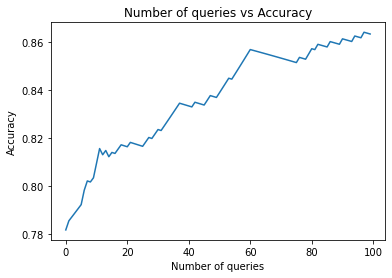

Highest accuracy: 0.864


In [18]:
plot_accuracy(scores_zlg)
print('Highest accuracy:', max(scores_zlg))

In [13]:
print('List of queried points')
print(queried_zlg)

List of queried points
[115, 123, 228, 178, 16, 130, 388, 41, 74, 101, 345, 89, 223, 244, 379, 226, 146, 85, 97, 311, 261, 86, 147, 380, 151, 215, 91, 74, 198, 114, 83, 235, 88, 78, 118, 187, 105, 7, 56, 333, 378, 93, 202, 134, 264, 153, 81, 69, 224, 134, 266, 73, 83, 72, 52, 383, 149, 76, 62, 383, 75, 87, 385, 232, 49, 231, 134, 145, 252, 140, 104, 232, 43, 22, 373, 54, 141, 237, 193, 88, 70, 17, 11, 253, 97, 190, 258, 42, 151, 44, 116, 285, 57, 90, 123, 126, 255, 164, 125, 124]


### Random Query

In [14]:
%%time

# copy data for use in this section
Xk_rand = copy.deepcopy(Xk)
Yk_rand = copy.deepcopy(Yk)
Xu_rand = copy.deepcopy(Xu)
Yu_rand = copy.deepcopy(Yu)

# variables
n_samples = X.shape[0]
n_l = Xk_rand.shape[0]
labeled_rand = [i for i in range(200)]
unlabeled_rand = [i for i in range(200,673)]

# initialize components
Delta = zlg.laplacian_matrix(X,t=0)
fu,Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_rand,unlabeled_rand,Yk)


# run required iterations
queried_rand = []
scores_rand = []
for count in range(100):
    
    # select unlabeled instance 
    query_idx = np.random.randint(low=0,high=len(unlabeled_rand),size=1)[0] # random unlabeled point
    queried_rand.append(query_idx)

    # add instance to labeled set
    Yk_rand = np.append(Yk_rand,Yu_rand[query_idx])
    Xk_rand = np.append(Xk_rand,[Xu_rand[query_idx,:]],axis=0)
    n_l += 1
    labeled_rand.append(unlabeled_rand.pop(0))  # move first element in unlabeled to end of labeled list

    # remove instance from unlabeled set
    Yu_rand = np.delete(Yu_rand,query_idx)
    Xu_rand = np.delete(Xu_rand,query_idx, 0)

    # update Laplacian
    Delta = zlg.laplacian_matrix(np.concatenate((Xk_rand,Xu_rand),axis=0), t=0)

    # calculate minimum energy solution for remaining unlabeled
    fu, Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_rand, unlabeled_rand,Yk_rand)

    # score model by testing on all unlabeled points left at each step
    scores_rand.append(score_model(fu, Yu_rand))

CPU times: user 1min 54s, sys: 804 ms, total: 1min 55s
Wall time: 54.6 s


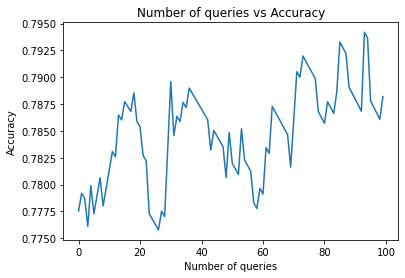

Highest accuracy: 0.7941952506596306


In [19]:
plot_accuracy(scores_rand)
print('Highest accuracy:', max(scores_rand))

In [16]:
print('List of queried points')
print(queried_rand)

List of queried points
[131, 145, 452, 121, 449, 311, 9, 156, 6, 340, 218, 80, 355, 51, 120, 106, 357, 424, 310, 184, 289, 219, 346, 250, 37, 45, 437, 412, 0, 13, 76, 278, 17, 331, 42, 163, 98, 426, 230, 387, 410, 309, 388, 47, 254, 327, 144, 42, 246, 82, 43, 414, 164, 142, 17, 248, 115, 214, 44, 303, 412, 202, 146, 365, 327, 316, 117, 260, 192, 339, 73, 263, 233, 296, 231, 289, 288, 58, 275, 329, 362, 199, 97, 168, 2, 5, 11, 169, 197, 174, 263, 116, 171, 168, 179, 216, 10, 281, 241, 147]


### Comparison

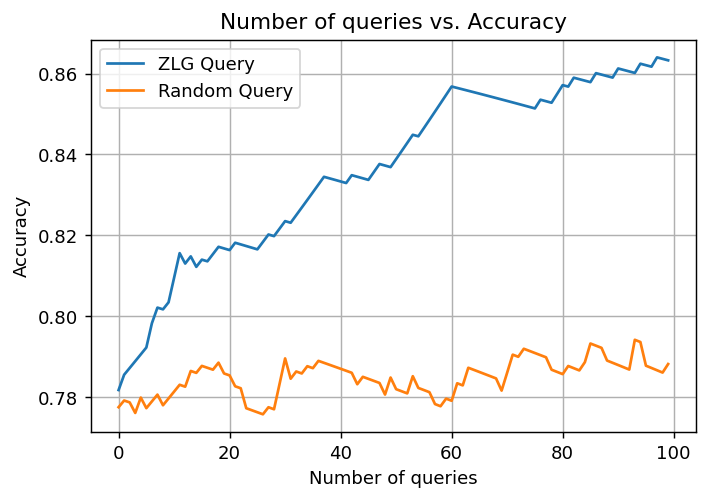

In [17]:
# plot both together
fig, ax = plt.subplots(dpi=130)
ax.plot(scores_zlg, label='ZLG Query')
ax.plot(scores_rand,label='Random Query')
plt.xlabel('Number of queries')
plt.ylabel('Accuracy')
plt.title('Number of queries vs. Accuracy')
plt.grid()
plt.legend()       
plt.show()

# 1.6. Bonus question 

**Answer the following questions. (Your grade will not exceed 100 for this homework.)**

#### 1. For this dataset, how many labeled data points do you actually need to train the model sufficiently well? 
#### 2. And why?